<a href="https://colab.research.google.com/github/nick11roberts/noise-weight-theft/blob/master/mnist_siamese_one_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation='linear')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1166 - accuracy: 0.8501 - val_loss: 0.0719 - val_accuracy: 0.9186
Epoch 2/20
108400/108400 [==============================] - 4s 36us/step - loss: 0.0748 - accuracy: 0.9190 - val_loss: 0.0595 - val_accuracy: 0.9355
Epoch 3/20
108400/108400 [==============================] - 4s 36us/step - loss: 0.0613 - accuracy: 0.9396 - val_loss: 0.0517 - val_accuracy: 0.9443
Epoch 4/20
108400/108400 [==============================] - 4s 36us/step - loss: 0.0533 - accuracy: 0.9508 - val_loss: 0.0490 - val_accuracy: 0.9472
Epoch 5/20
108400/108400 [===========================

In [0]:
pixel_batch = []

for i in range(28):
  for j in range(28):
    pix_img = np.zeros_like(x_train[0])
    pix_img[i, j] = 1.0 # Could also try random [0, 1] values
    
    pixel_batch.append(pix_img)
    
pixel_batch = np.stack(pixel_batch)

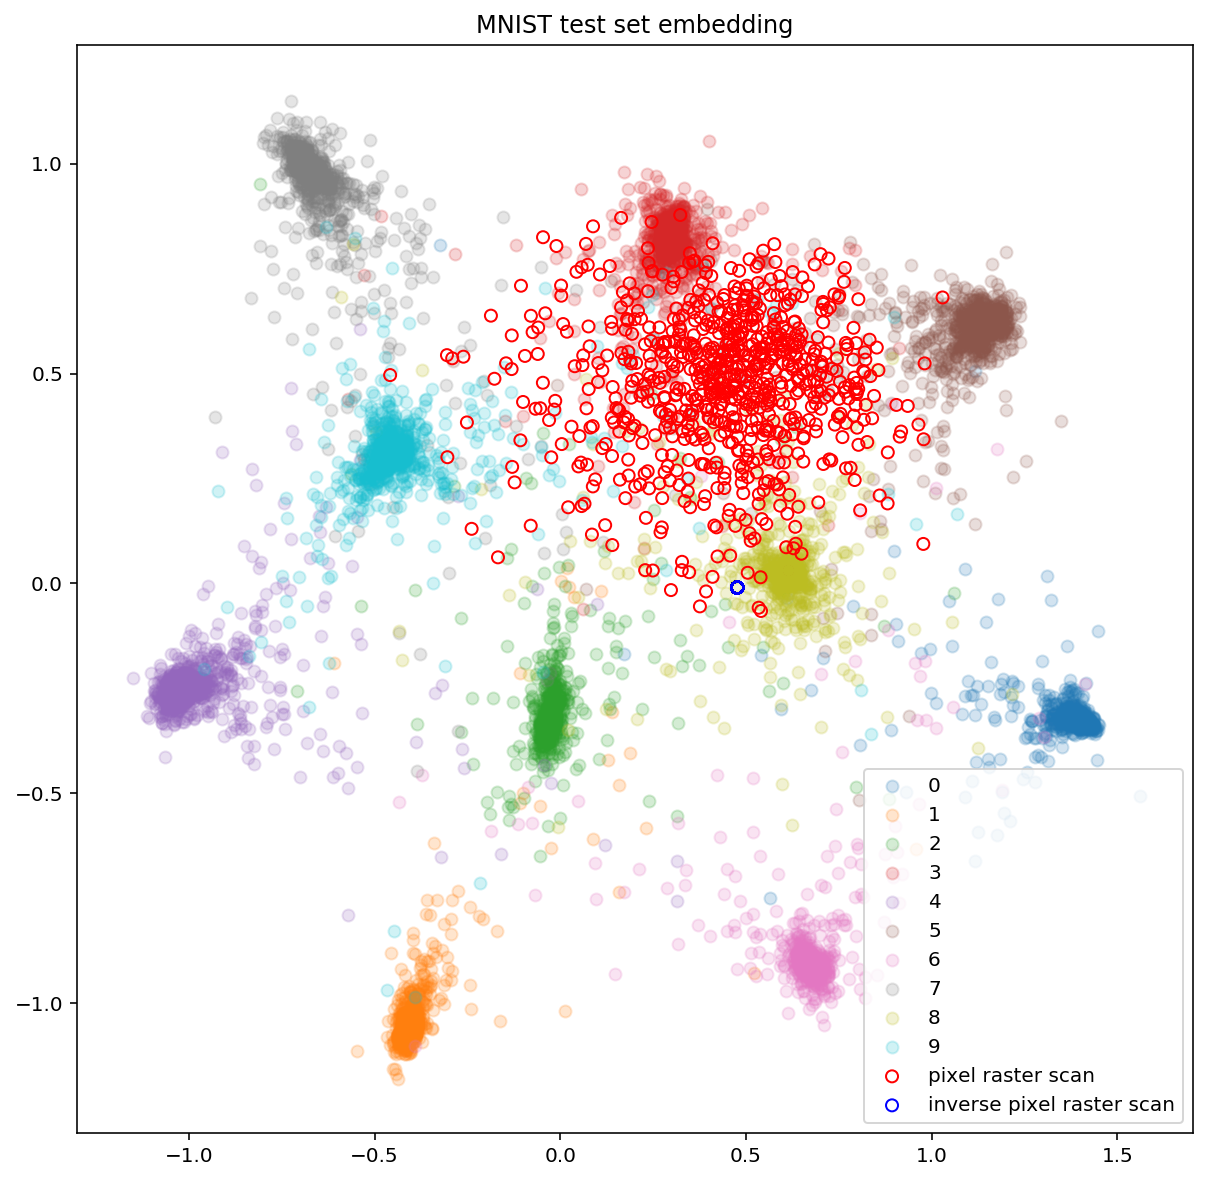

In [0]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


x_test_emb = base_network.predict(x_test)


plt.figure(figsize=(10, 10))
#plt.xlim(-2.0, 2.0)
#plt.ylim(-2.0, 2.0)
for i in range(10):
  plt.scatter(x_test_emb[y_test == i][:, 0], 
              x_test_emb[y_test == i][:, 1], 
              label='{}'.format(i), alpha=0.2)
  
  
pixel_batch_emb = base_network.predict(pixel_batch)
plt.scatter(pixel_batch_emb[:, 0], 
            pixel_batch_emb[:, 1], 
            label='pixel raster scan', 
            alpha=1.0, 
            color='red', 
            facecolors='none')

pixel_batch_inv_emb = base_network.predict(1.0 - pixel_batch)
plt.scatter(pixel_batch_inv_emb[:, 0], 
            pixel_batch_inv_emb[:, 1], 
            label='inverse pixel raster scan', 
            alpha=1.0, 
            color='blue', 
            facecolors='none')



plt.title("MNIST test set embedding")
plt.legend()
plt.show()

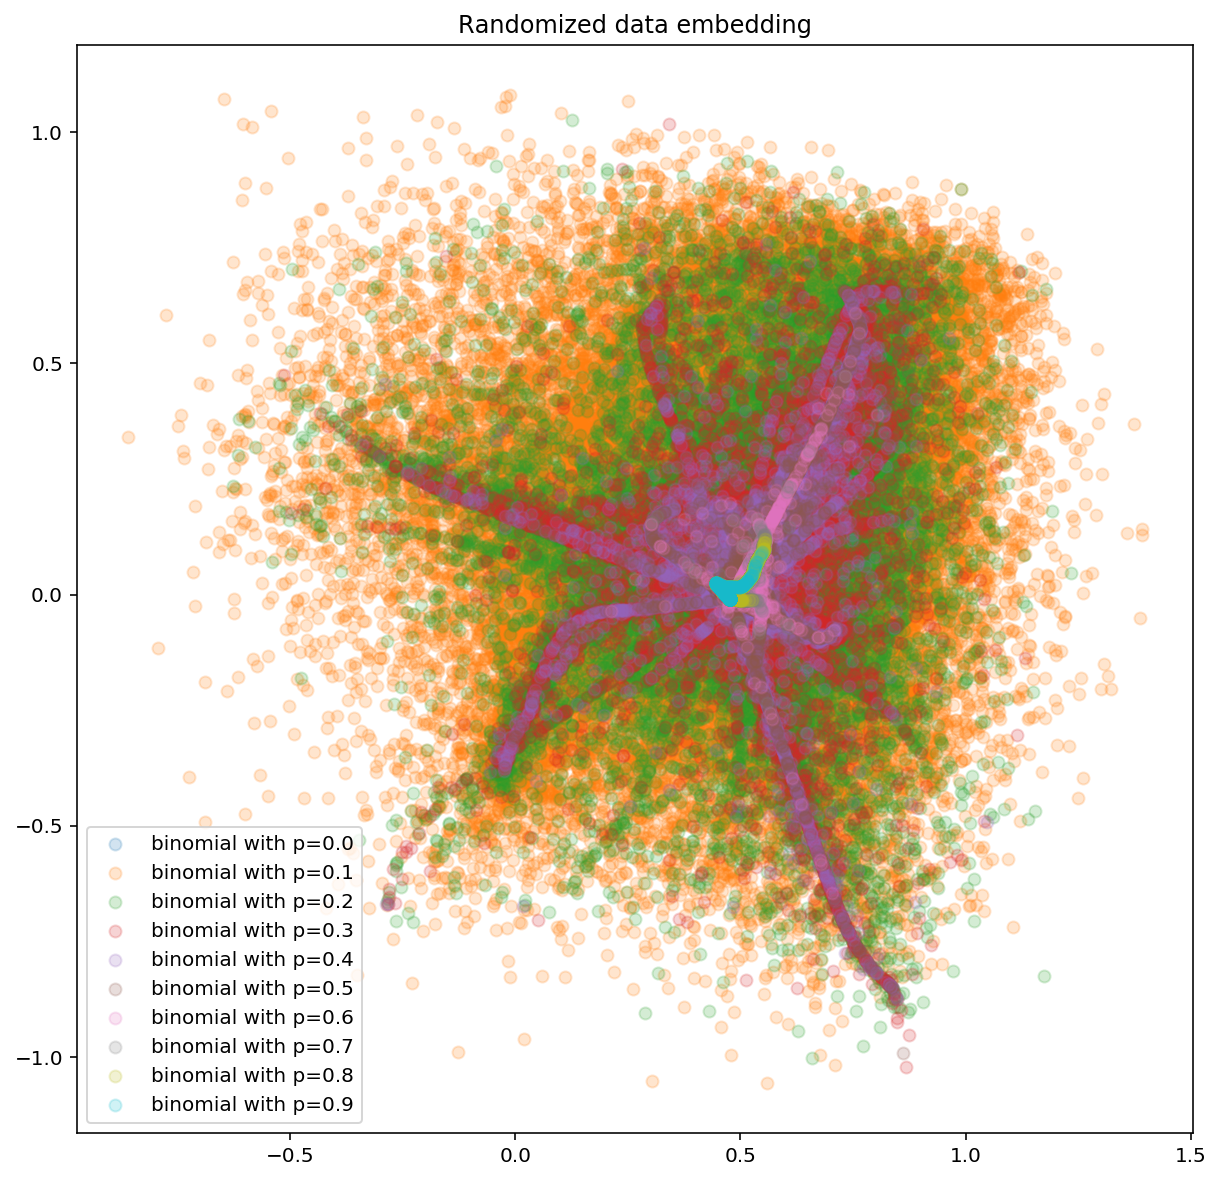

In [0]:
plt.figure(figsize=(10, 10))

x_test_emb = base_network.predict(x_test)

# Generate stimulus response pairs
x_rand = []
y_rand = []
for p in np.arange(0, 1, 0.1):
  x_rand.append(np.random.binomial(1, p, (50000, 28, 28)))
  y_rand.append(base_network.predict(x_rand[-1]))
  
  plt.scatter(y_rand[-1][:, 0], 
              y_rand[-1][:, 1], 
              label='binomial with p={0:0.1f}'.format(p), 
              alpha=0.2)
  
x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)



plt.title("Randomized data embedding")
plt.legend()
plt.show()

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = (x_rand, y_rand), (x_test, y_test)

print(x_train.shape)
print(x_test.shape)

x_train = np.expand_dims(x_rand, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
input_shape = x_train.shape[1:]

# network definition
model_steal = Sequential()
model_steal.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_steal.add(Conv2D(64, (3, 3), activation='relu'))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
#model_steal.add(Dropout(0.25))
model_steal.add(Flatten())
model_steal.add(Dense(128, activation='relu'))
#model_steal.add(Dropout(0.5))
model_steal.add(Dense(2, activation='linear'))

model_steal.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae', 'mse'])

model_steal.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=10,
               verbose=1)


#x_test_emb = base_network.predict(x_test)

#score = model_steal.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

(500000, 28, 28)
(10000, 28, 28)
Epoch 1/10
500000/500000 [==============================] - 37s 74us/step - loss: 0.0149 - mean_absolute_error: 0.0565 - mean_squared_error: 0.0149
Epoch 2/10
500000/500000 [==============================] - 36s 72us/step - loss: 0.0106 - mean_absolute_error: 0.0472 - mean_squared_error: 0.0106
Epoch 3/10
500000/500000 [==============================] - 37s 73us/step - loss: 0.0095 - mean_absolute_error: 0.0429 - mean_squared_error: 0.0095
Epoch 4/10
500000/500000 [==============================] - 36s 72us/step - loss: 0.0086 - mean_absolute_error: 0.0404 - mean_squared_error: 0.0086
Epoch 5/10
500000/500000 [==============================] - 36s 72us/step - loss: 0.0079 - mean_absolute_error: 0.0387 - mean_squared_error: 0.0079
Epoch 6/10
500000/500000 [==============================] - 32s 64us/step - loss: 0.0073 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0073
Epoch 7/10
500000/500000 [==============================] - 32s 65us/step - los

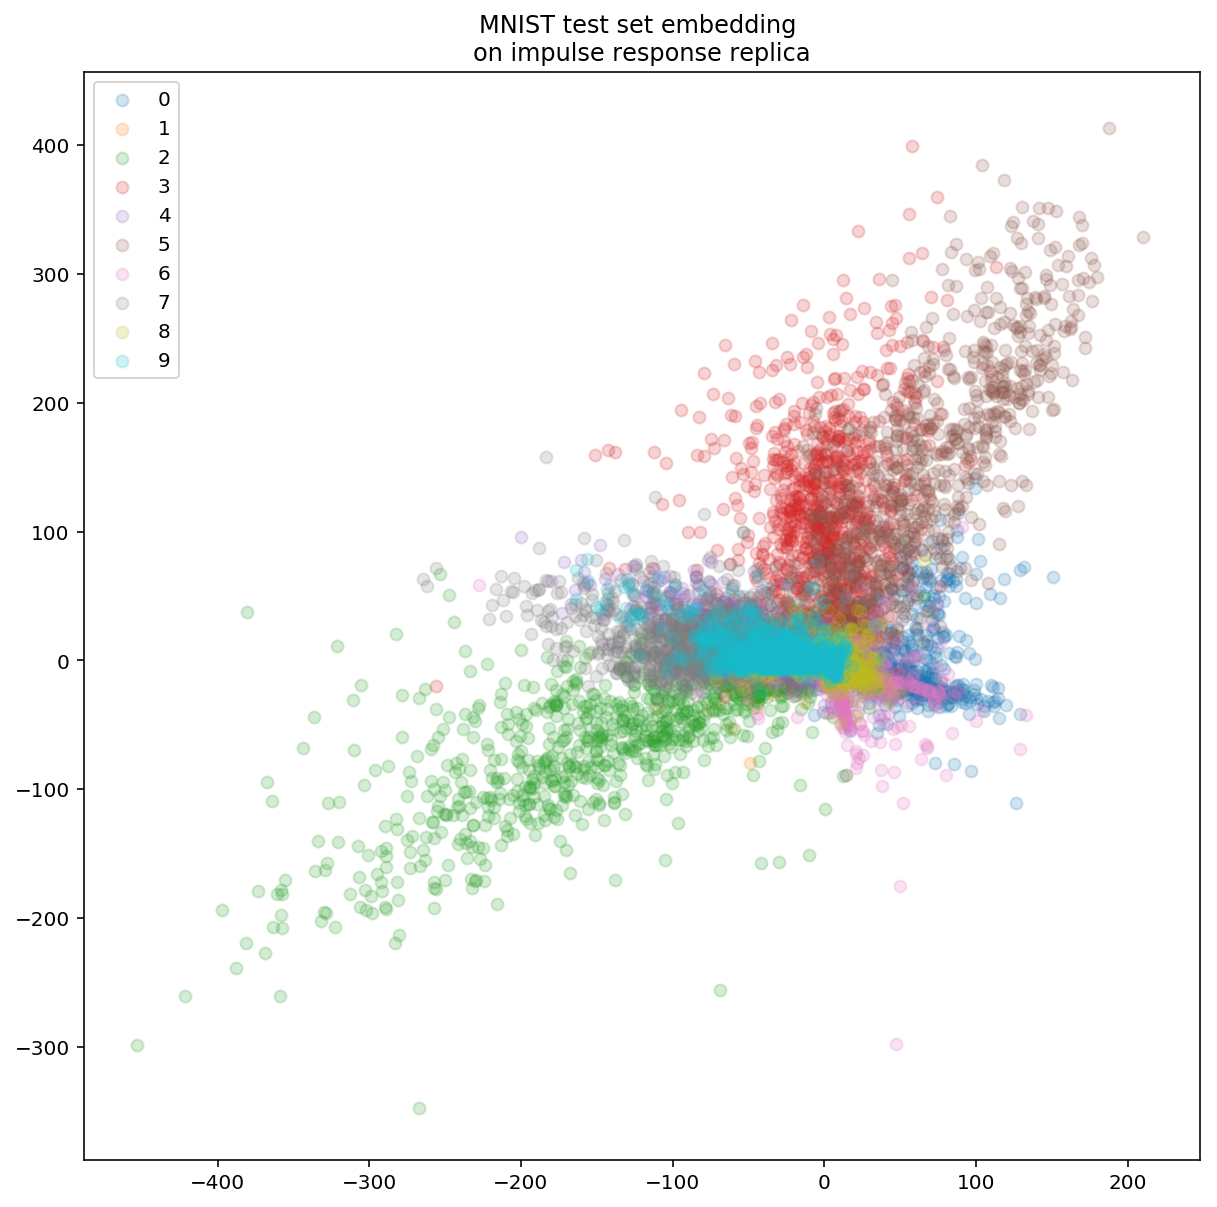

In [0]:
x_test_emb = model_steal.predict(x_test)


plt.figure(figsize=(10, 10))
#plt.xlim(-2.0, 2.0)
#plt.ylim(-2.0, 2.0)
for i in range(10):
  plt.scatter(x_test_emb[y_test == i][:, 0], 
              x_test_emb[y_test == i][:, 1], 
              label='{}'.format(i), alpha=0.2)


plt.title("MNIST test set embedding \non impulse response replica")
plt.legend()
plt.show()

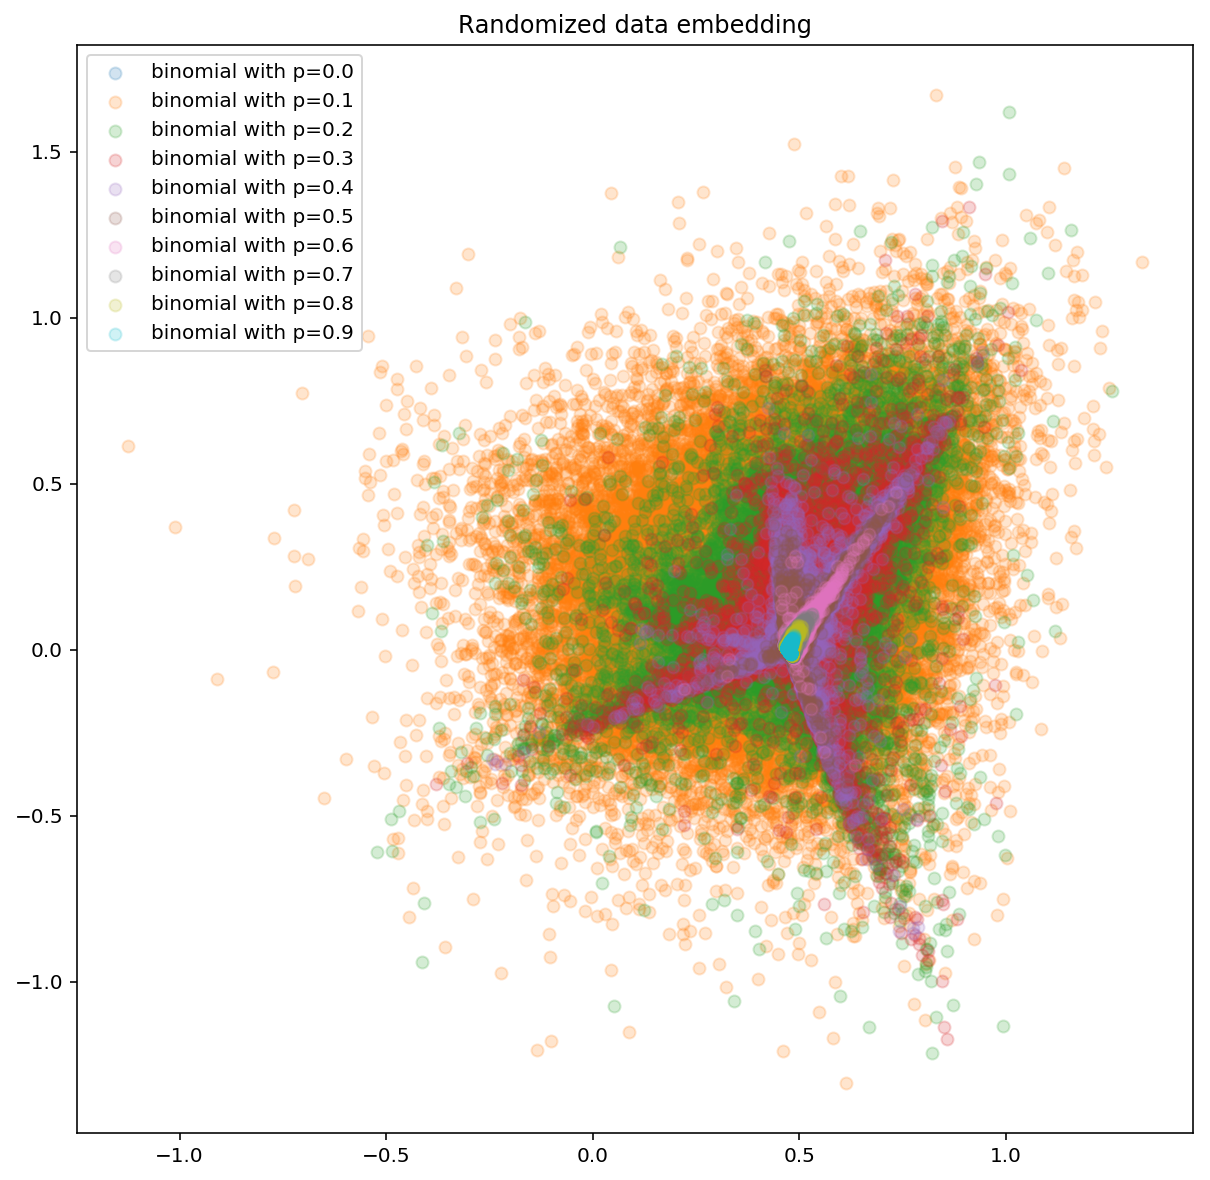

In [0]:
plt.figure(figsize=(10, 10))

# Generate stimulus response pairs
x_rand = []
y_rand = []
for p in np.arange(0, 1, 0.1):
  x_rand.append(np.random.binomial(1, p, (50000, 28, 28, 1)))
  y_rand.append(model_steal.predict(x_rand[-1]))
  
  plt.scatter(y_rand[-1][:, 0], 
              y_rand[-1][:, 1], 
              label='binomial with p={0:0.1f}'.format(p), 
              alpha=0.2)
  
x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)



plt.title("Randomized data embedding")
plt.legend()
plt.show()